In [1]:
!pip install transformers datasets sentencepiece rouge-score evaluate accelerate


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.4 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=5a84c7c4587667d60c4cf37d0a6c8a9221f4ec29e0c8687134d5f36bdc785229
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge-score


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

## Data Loading

In [8]:
df = pd.read_csv("/content/samsum_train.csv")
test = pd.read_csv("/content/samsum_test.csv")
sample = pd.read_csv("/content/sample_submission.csv")

In [9]:
print("Train",df.shape)
print("Test",test.shape)


Train (10312, 3)
Test (2210, 2)


In [10]:
print("===== Columns =====")
print(df.columns)

print("\n===== Basic Info =====")
print(df.info())

print("\n===== Null Values =====")
print(df.isnull().sum())

===== Columns =====
Index(['id', 'dialogue', 'summary'], dtype='object')

===== Basic Info =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10312 entries, 0 to 10311
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        10312 non-null  object
 1   dialogue  10311 non-null  object
 2   summary   10312 non-null  object
dtypes: object(3)
memory usage: 241.8+ KB
None

===== Null Values =====
id          0
dialogue    1
summary     0
dtype: int64


In [11]:
print("\n===== Sample Rows =====")
item = df.sample(1, random_state=40)

print("Dialogue")
print(item.dialogue)

print("Summary")
print(item.summary)


===== Sample Rows =====
Dialogue
10280    John: Are you home?\r\nAnn: yes, in bed\r\nJoh...
Name: dialogue, dtype: object
Summary
10280    A is at home in bed.
Name: summary, dtype: object


### Computer Word Length

In [14]:
df["dialogue_len_words"] = df["dialogue"].astype(str).apply(lambda x: len(x.split()))
df["summary_len_words"]  = df["summary"].astype(str).apply(lambda x: len(x.split()))

print("\n===== Dialogue Length (Characters) =====")
print(df["dialogue_len_char"].describe())

print("\n===== Summary Length (Characters) =====")
print(df["summary_len_char"].describe())


===== Dialogue Length (Characters) =====
count    10312.000000
mean       510.079713
std        403.216424
min          3.000000
25%        218.000000
50%        397.000000
75%        692.000000
max       5492.000000
Name: dialogue_len_char, dtype: float64

===== Summary Length (Characters) =====
count    10312.000000
mean       101.256788
std         58.488346
min          4.000000
25%         56.000000
50%         88.000000
75%        134.000000
max        300.000000
Name: summary_len_char, dtype: float64


### Compute character Lengths


In [13]:
df["dialogue_len_char"] = df["dialogue"].astype(str).apply(len)
df["summary_len_char"]  = df["summary"].astype(str).apply(len)


print("\n===== Dialogue Length (Words) =====")
print(df["dialogue_len_words"].describe())

print("\n===== Summary Length (Words) =====")
print(df["summary_len_words"].describe())





===== Dialogue Length (Words) =====
count    10312.000000
mean        93.599884
std         74.067218
min          1.000000
25%         40.000000
50%         73.000000
75%        127.000000
max        638.000000
Name: dialogue_len_words, dtype: float64

===== Summary Length (Words) =====
count    10312.000000
mean        20.385279
std         11.235380
min          1.000000
25%         12.000000
50%         18.000000
75%         27.000000
max         60.000000
Name: summary_len_words, dtype: float64


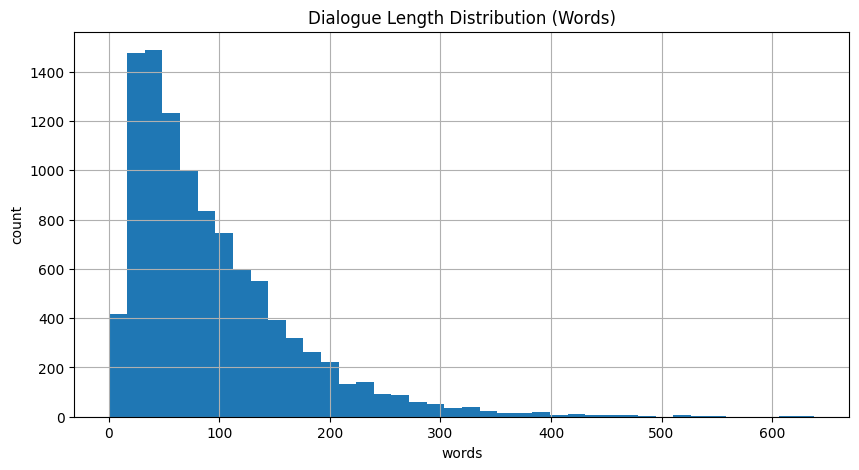

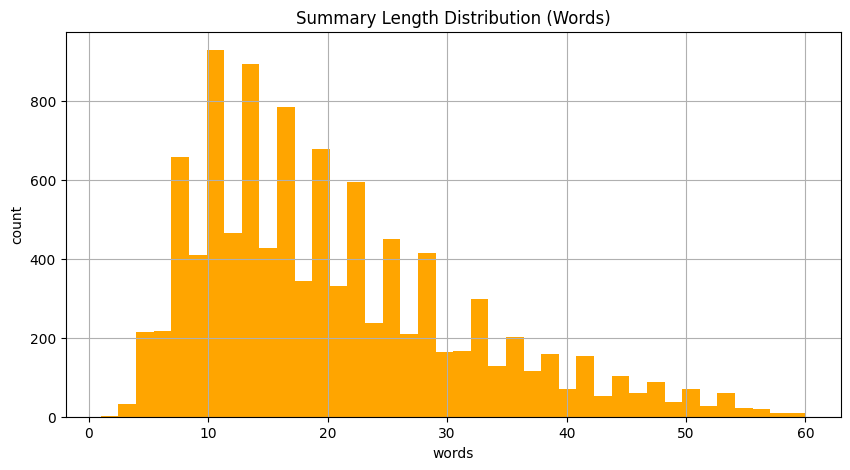

In [15]:
plt.figure(figsize=(10,5))
df["dialogue_len_words"].hist(bins=40)
plt.title("Dialogue Length Distribution (Words)")
plt.xlabel("words")
plt.ylabel("count")
plt.show()

plt.figure(figsize=(10,5))
df["summary_len_words"].hist(bins=40, color='orange')
plt.title("Summary Length Distribution (Words)")
plt.xlabel("words")
plt.ylabel("count")
plt.show()


## Noise

In [16]:
def check_noise(text):
    if not isinstance(text, str):
        return False
    noise_keywords = ["http", "www", "AM", "PM", "timestamp"]
    text = text.lower()
    return any(k.lower() in text for k in noise_keywords)

df["dialogue"] = df["dialogue"].fillna("")
df["has_noise"] = df["dialogue"].apply(check_noise)

print("\nNoise present in dialogues:", df["has_noise"].mean()*100, "%")



Noise present in dialogues: 45.50038789759503 %


In [17]:
import re
import pandas as pd

def clean_dialogue(text):
    if not isinstance(text, str):
        return text

    text = text.strip()

    # Remove URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)

    # Remove timestamps like 10:30 PM / 5:00 am / 23:59
    text = re.sub(r'\b\d{1,2}:\d{2}\s?(AM|PM|am|pm)?\b', '', text)

    # Remove long emoji chains (but allow occasional emoji)
    text = re.sub(r'([\U00010000-\U0010ffff]{2,})', '', text)

    # Remove repeated punctuation e.g. !!!!! or ????
    text = re.sub(r'([!?.,])\1{2,}', r'\1', text)

    # Collapse excessive whitespace
    text = re.sub(r'\s+', ' ', text)

    return text.strip()

# Apply to dataset

df["dialogue"] = df["dialogue"].apply(clean_dialogue)
print("Cleaning Done")
print(df.head())


Cleaning Done
         id                                           dialogue  \
0  13818399  Max: How's your job hunt going? Dorothy: Uhh, ...   
1  13865364  Jim: We should meet at the cathedral church Ti...   
2  13682301  Maryann: How long do I cook rice? Howard: What...   
3  13730492  Eric: Wya? Eve: College Green Eric: stay there...   
4  13728552  Ethan: Wanna play basketball tomorrow? Logan: ...   

                                             summary  dialogue_len_words  \
0  B has been looking for a job and sending a hun...                  72   
1  A, Tim and Margaret will meet at the cathedral...                  23   
2  It takes up to 25 minutes to cook brown rice a...                 147   
3                  B will pick A from College Green.                  14   
4  A and B will play basketball tomorrow. A has a...                  19   

   summary_len_words  dialogue_len_char  summary_len_char  has_noise  
0                 28                352               136    

In [18]:
def check_noise(text):
    if not isinstance(text, str):
        return False
    noise_keywords = ["http", "www", "AM", "PM", "timestamp"]
    text = text.lower()
    return any(k.lower() in text for k in noise_keywords)

df["dialogue"] = df["dialogue"].fillna("")
df["has_noise"] = df["dialogue"].apply(check_noise)

print("\nNoise after cleaning in dialogues:", df["has_noise"].mean()*100, "%")



Noise after cleaning in dialogues: 45.180372381691235 %


In [19]:
import re

def count_speakers(dialog):
    speakers = re.findall(r"[A-Za-z0-9_]+:", dialog)
    return len(set(speakers))

df["unique_speakers"] = df["dialogue"].apply(count_speakers)

print("\n===== Unique Speakers Stats =====")
print(df["unique_speakers"].describe())
print(df["unique_speakers"].value_counts().head())



===== Unique Speakers Stats =====
count    10312.000000
mean         2.458980
std          0.895719
min          0.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         14.000000
Name: unique_speakers, dtype: float64
unique_speakers
2    7155
3    2155
4     667
5     189
6      71
Name: count, dtype: int64


### Hyperparameter
for T5
*   max_input_length  = 512
*  max_target_length = 80

Reason:
* 75% dialogue fit well under 512 tokens
* summaries never exceed 80 meaningful tokens





## T5 Training + Evaluation Pipeline

In [20]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

print(f"Train DataFrame shape: {train_df.shape}")
print(f"Validation DataFrame shape: {val_df.shape}")

Train DataFrame shape: (8249, 9)
Validation DataFrame shape: (2063, 9)


In [22]:
import os
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "offline"
os.environ["WANDB_SILENT"] = "true"


In [ ]:
import pandas as pd
from datasets import Dataset, DatasetDict
from transformers import (
    T5ForConditionalGeneration,
    T5TokenizerFast,
    Trainer,
    TrainingArguments,
    DataCollatorForSeq2Seq
)
import evaluate

# -----------------------------------------
# Load your cleaned train + val
# -----------------------------------------
train_df = train_df[["dialogue", "summary"]]
val_df = val_df[["dialogue", "summary"]]

dataset = DatasetDict({
    "train": Dataset.from_pandas(train_df),
    "validation": Dataset.from_pandas(val_df)
})

# -----------------------------------------
# Model + Tokenizer
# -----------------------------------------
model_name = "t5-large" # Reverted to original model size
tokenizer = T5TokenizerFast.from_pretrained(model_name)

max_input_length = 512
max_target_length = 80

# -----------------------------------------
# Preprocess Function
# IMPORTANT: padding=True + label padding
# -----------------------------------------
def preprocess(batch):
    inputs = ["summarize: " + d for d in batch["dialogue"]]

    model_inputs = tokenizer(
        inputs,
        max_length=max_input_length,
        truncation=True,
        padding="max_length", # Ensure explicit padding during tokenization
    )

    labels = tokenizer(
        batch["summary"],
        max_length=max_target_length,
        truncation=True,
        padding="max_length", # Ensure explicit padding during tokenization
    )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_dataset = dataset.map(
    preprocess,
    batched=True,
    remove_columns=dataset["train"].column_names
)

# -----------------------------------------
# Model
# -----------------------------------------
model = T5ForConditionalGeneration.from_pretrained(model_name)

# -----------------------------------------
# Metric
# -----------------------------------------
rouge = evaluate.load("rouge")

def compute_metrics(eval_pred):
    preds, labels = eval_pred

    preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    labels = [[t for t in l if t != -100] for l in labels]
    labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    result = rouge.compute(
        predictions=preds,
        references=labels,
        use_stemmer=True
    )
    return result


# -----------------------------------------
# Data Collator (Fixes Your Error)
# -----------------------------------------
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    padding=True
)

# -----------------------------------------
# Training Args
# -----------------------------------------
training_args = TrainingArguments(
    output_dir="./t5-large-dialogue-sum",
    # evaluation_strategy="steps", # Removed due to TypeError with this version of transformers
    logging_steps=200,
    eval_steps=800,
    save_steps=800,
    learning_rate=3e-4,
    per_device_train_batch_size=1,     # Adjusted for OutOfMemoryError
    per_device_eval_batch_size=1,      # Adjusted for OutOfMemoryError
    gradient_accumulation_steps=8,     # Adjusted to compensate for smaller batch size
    num_train_epochs=3,
    weight_decay=0.01,
    warmup_ratio=0.1,
    save_total_limit=2,
    # predict_with_generate=True, # Removed due to TypeError with this version of transformers
    fp16=True,
    # load_best_model_at_end=True, # Removed to avoid ValueError as evaluation_strategy could not be set
)

# -----------------------------------------
# Trainer
# -----------------------------------------
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator, # Re-added data_collator
    compute_metrics=compute_metrics
)

trainer.train()


Map:   0%|          | 0/8249 [00:00<?, ? examples/s]

Map:   0%|          | 0/2063 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-3470863578.py:122: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
200,431843614.720000


## Evaluate Model

In [ ]:
metrics = trainer.evaluate()
print(metrics)
